In [18]:
import json
import datetime as dt
import pandas as pd

I started by finding the latitude and longitude boundaries of campus. I will draw a circular boundary from the midpoint of campus that should encompass all parts of campus with a bit of leeway. Even though this will extend slightly outside the range of campus it should be close enough since most of the extra area included is woods or streets I don't spend time on, so it shouldn't add extra data that isn't relevant. I used a website to help me locate where this circle is and its radius. I found a midpoint at: 38.990262, -76.943013 with a radium of 986.61 meters.

I started by finding the latitude and longitude boundaries campus, and the surrounding areas in College Park (basically from the apartments off of South Campus up north to where North Campus ends. And then far East enough to reach my home, and encompassing campas in the West). Using google maps I found that this area stretches over latitudes: 38.977086 to 39.000676 and it stretches over longitudes: -76.925135 to -76.953067. Since I plan to calculate travel times only in the campus area, I want to use only travel segments that start and end within these latitude and longitude ranges. We'll have to pick out these lat/long data from our JSON data that was downloaded from Google. <br>
Using a JSON tree plugin for Notepad++ I got a good idea of how the data is organized. The top level of JSON is a single object named "timelineObjects." This contains an array of all the data collected by Google as a sequence of numbers. Each of these objects can be either a "placeVisit" or an "activitySegment." These two are basically interwoven with each other since each placeVisit is a location that a user ended a trip in, and each activitySegment represents a distance traveled by a user. <br>
Each of these objects have their own elements. activitySegment has: startLocation, endLocation, duration, distance (in meters), activityType, confidence, activities, waypointPath, and simplifiedRawPath. Most of these are self-explanatory, but the remainder are actually simple as well. activity is the method of transportation (cycling, in_passenger_vehicle, train, etc.), confidence is how confident Google is that this method of transportation predicted is correct (can be HIGH, MEDIUM, etc.). activities contains the list of possible activities and the probability that Google thinks you were conducting this specific activity (essentially a further breakdown of 'activity'). waypointPath is the lat/long coordinates of each waypoint google has marked along your journey. simplifiedRawPath seems to be just waypointPath with less waypoints, but I'm not entirely sure what it represents. <br>
placeVisit has elements: location, duration, placeConfidence, childVisits, visitConfidence, otherCandidateLocations, placeVisitType, and a few others. These are mostly self explanatory as well. placeConfidence is how likely Google thinks that the location given is correct (I assume this is done since GPS isn't hyper-accurate, so they try to predict exact location). childVisits is more local locations that may have been visited (like individual shops within a mall). placeVisitType is a value like SINGLE_PLACE. <br>
Many of these attributes for activitySegment will be useful like startLocation, endLocation, duration, distance, acitvityType, and confidence. For placeVisit, I don't expect to need this data, however, it may turn out to be useful for determining which activitySegments ended on campus by checking of the placeVisit Location is a building on campus or campus itself 

In [6]:
# create a list of all files using loops cuz I am lazy
months = ["JANUARY","FEBRUARY","MARCH","APRIL","MAY","JUNE","JULY","AUGUST","SEPTEMBER","OCTOBER","NOVEMBER","DECEMBER"]
years = ["2019_","2020_","2021_","2022_"]
fileList = []
for year in years:
    for month in months:
        fileList.append(f"{year}{month}"+".json")
# get rid of the extra files that account for months that are pre-August 2019, and post-May 2022    
fileList = fileList[7:41]
        
# Create a dataframe, and then append each file's data onto it by looping through them
# This takes a good 5 seconds on my PC
timelineData = pd.DataFrame()
for file in fileList:
    # Load the data in with loads() to be ready to convert to a dataframe
    with open(file,'r') as f:
        data_temp = json.loads(f.read())
    # Then use pd.json_normalize to flatten the data since it was in nested JSON object
    # record_path tells it where to look at data to normalize
    df_temp = pd.json_normalize(data_temp, record_path = ['timelineObjects'])
    timelineData = pd.concat([timelineData, df_temp], ignore_index = True)
timelineData

,activitySegment.startLocation.latitudeE7,activitySegment.startLocation.longitudeE7,activitySegment.startLocation.sourceInfo.deviceTag,activitySegment.endLocation.latitudeE7,activitySegment.endLocation.longitudeE7,activitySegment.endLocation.sourceInfo.deviceTag,activitySegment.duration.startTimestamp,activitySegment.duration.endTimestamp,activitySegment.distance,activitySegment.activityType,...,placeVisit.checkin.device.android.fingerprint,activitySegment.transitPath.distanceMeters,activitySegment.parkingEvent.location.sourceInfo.deviceTag,activitySegment.editConfirmationStatus,activitySegment.lastEditedTimestamp,activitySegment.editActionMetadata.activitySegment.activityType,activitySegment.editActionMetadata.activitySegment.activityConfidence,activitySegment.editActionMetadata.editHistory.editEvent,activitySegment.transitPath.stopTimesInfo,activitySegment.startLocation.semanticType
0,409055734.0,-740184674.0,-1.951075e+09,411579275.0,-740794651.0,-1.951075e+09,2019-08-01T02:07:55.374Z,2019-08-01T02:40:28.486Z,32480.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,411579275.0,-740794651.0,-1.951075e+09,410441704.0,-740664597.0,-1.951075e+09,2019-08-01T12:26:34.532Z,2019-08-01T12:54:31.018Z,14412.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,410441704.0,-740664597.0,-1.951075e+09,411579275.0,-740794651.0,-1.951075e+09,2019-08-01T14:00:39.657Z,2019-08-01T14:24:01.362Z,13425.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7786,389960067.0,-769283676.0,-1.787875e+09,389988793.0,-769108098.0,-1.787875e+09,2022-05-03T01:37:14.002Z,2022-05-03T01:40:33.896Z,1573.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7788,389989306.0,-769119663.0,-1.787875e+09,389960081.0,-769283696.0,-1.787875e+09,2022-05-03T01:53:29.027Z,2022-05-03T01:57:27.894Z,1471.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This data obviously needs a lot of clean-up. I saw some libraries like Glom that could've been used to extract data more nicely, but since I only need a few attributes it's simple enough to just clean up the data after putting it in the dataframe.

In [7]:
# Start by dropping all of the placeVisits by getting rid of rows that don't have data in activitySegment columns
timelineData.dropna(subset=['activitySegment.startLocation.latitudeE7'],inplace=True)

# Next include only the columns we actually care about
timelineDataClean = timelineData[timelineData.columns[[0,1,3,4,6,7,8,9,10]]]

# Finally let's rename these columns
timelineDataClean.set_axis(['startLat', 'startLng', 'endLat', 'endLng', 'startTime', 'endTime', 'dist', 'activity', 'confidence'], axis=1, inplace=True)
timelineDataClean

,startLat,startLng,endLat,endLng,startTime,endTime,dist,activity,confidence
0,409055734.0,-740184674.0,411579275.0,-740794651.0,2019-08-01T02:07:55.374Z,2019-08-01T02:40:28.486Z,32480.0,IN_PASSENGER_VEHICLE,HIGH
2,411579275.0,-740794651.0,410441704.0,-740664597.0,2019-08-01T12:26:34.532Z,2019-08-01T12:54:31.018Z,14412.0,IN_PASSENGER_VEHICLE,HIGH
4,410441704.0,-740664597.0,411579275.0,-740794651.0,2019-08-01T14:00:39.657Z,2019-08-01T14:24:01.362Z,13425.0,IN_PASSENGER_VEHICLE,HIGH
6,411579275.0,-740794651.0,410441704.0,-740664597.0,2019-08-02T13:24:23.363Z,2019-08-02T13:52:16.803Z,14006.0,IN_PASSENGER_VEHICLE,HIGH
8,410441704.0,-740664597.0,411579275.0,-740794651.0,2019-08-02T15:06:32.845Z,2019-08-02T15:30:32.931Z,13848.0,IN_PASSENGER_VEHICLE,HIGH
...,...,...,...,...,...,...,...,...,...
7780,389882621.0,-769400751.0,389959941.0,-769283339.0,2022-05-02T18:49:18.823Z,2022-05-02T18:55:47.877Z,1463.0,CYCLING,HIGH
7782,389960008.0,-769283846.0,389855696.0,-769412065.0,2022-05-02T21:25:52.727Z,2022-05-02T21:38:13.826Z,2084.0,IN_PASSENGER_VEHICLE,MEDIUM
7784,389864802.0,-769398963.0,389963207.0,-769289574.0,2022-05-02T22:50:13Z,2022-05-02T22:57:04.596Z,1783.0,IN_PASSENGER_VEHICLE,HIGH
7786,389960067.0,-769283676.0,389988793.0,-769108098.0,2022-05-03T01:37:14.002Z,2022-05-03T01:40:33.896Z,1573.0,IN_PASSENGER_VEHICLE,HIGH


Now that we've got our data cleaned up, we can start filtering it to ensure that we're only including data that takes place around UMD campus. In addition I'm going to drop any LOW confidence activities since Google doesn't display these in my account's timeline history. I don't believe that dropping these datapoints should skew the data since I expect the low confidence is due to bad GPS data, not due to any factors I plan to analyze such as duration or distance. 

In [90]:
# First let's ensure we only look at start and end locations that are on the campus
# This means filtering by latitudes between 38.977086 to 39.000676 and longitudes between -76.925135 to -76.953067
# These coordinates are represented without a decimal point though, so in reality we need to multiply these numbers by 10^7

criterian = (timelineDataClean['startLat'] < 390000676) & (timelineDataClean['startLat'] > 389770860)
criterian = criterian & (timelineDataClean['endLat'] < 390000676) & (timelineDataClean['endLat'] > 389770860)
criterian = criterian & (timelineDataClean['startLng'] < -769251350) & (timelineDataClean['startLng'] > -769530670)
criterian = criterian & (timelineDataClean['endLng'] < -769251350) & (timelineDataClean['endLng'] > -769530670)

# We also only want activitySegments where the confidence level is at least MEDIUM
criterian = criterian & ( (timelineDataClean['confidence'] == "MEDIUM") | (timelineDataClean['confidence'] == "HIGH") )

finalData = timelineDataClean[criterian]
finalData
#timelineDataClean[[(x == "LOW") for x in timelineDataClean['confidence']]]



,startLat,startLng,endLat,endLng,startTime,endTime,dist,activity,confidence
179,389886162.0,-769407629.0,389827510.0,-769486330.0,2019-08-22T14:47:36Z,2019-08-22T14:54:04Z,1411.0,CYCLING,HIGH
183,389915426.0,-769472858.0,389827510.0,-769486330.0,2019-08-22T16:00:27Z,2019-08-22T16:08:33Z,1766.0,CYCLING,HIGH
185,389827510.0,-769486330.0,389869183.0,-769425543.0,2019-08-22T16:24:47.363Z,2019-08-22T16:28:46.112Z,843.0,WALKING,HIGH
187,389821113.0,-769456484.0,389825567.0,-769367840.0,2019-08-22T16:35:58.161Z,2019-08-22T16:47:04.594Z,1913.0,IN_PASSENGER_VEHICLE,MEDIUM
192,389869183.0,-769425543.0,389827510.0,-769486330.0,2019-08-22T17:40:43.893Z,2019-08-22T17:41:36.598Z,737.0,WALKING,MEDIUM
...,...,...,...,...,...,...,...,...,...
7776,389932626.0,-769452798.0,389961560.0,-769286026.0,2022-05-02T16:09:50.303Z,2022-05-02T16:17:31.417Z,1606.0,CYCLING,HIGH
7778,389959980.0,-769283765.0,389882565.0,-769399702.0,2022-05-02T17:48:44.200Z,2022-05-02T17:54:50.017Z,1430.0,CYCLING,HIGH
7780,389882621.0,-769400751.0,389959941.0,-769283339.0,2022-05-02T18:49:18.823Z,2022-05-02T18:55:47.877Z,1463.0,CYCLING,HIGH
7782,389960008.0,-769283846.0,389855696.0,-769412065.0,2022-05-02T21:25:52.727Z,2022-05-02T21:38:13.826Z,2084.0,IN_PASSENGER_VEHICLE,MEDIUM


Next we've got to convert our startTime and endTime into a "duration" column in the dataframe. To do this we'll first have to clean up our startTime and endTime columns so that they are actual Datetime objects that we can calculate a difference between. We'll do this by string slicing to extract the individual parts of the date and time, then recombine them into a datetime object using pd.to_datetime(). Once we've got the datetimes, the library allows us to simply subtract them to create a timeDelta object that tells us how much time has passed between them. I'll then just convert this timeDelta into some number of seconds for ease of use.

In [92]:
# Turn off settingWithCopyWarning since it is meant to flag unpredictable behavior for chained-assignment. However it has false positives, like the below code that
# doesn't use chained-assignment, so i'll just get rid of the warning
#pd.options.mode.chained_assignment = None  # default='warn'
# First assemble all the data into a new dataframe that we'll need to create the datetime object from startTime
startDateTimeAttributes = pd.DataFrame()
startDateTimeAttributes['year'] = finalData['startTime'].str[0:4]
startDateTimeAttributes['month'] = finalData['startTime'].str[5:7]
startDateTimeAttributes['day'] = finalData['startTime'].str[8:10]
startDateTimeAttributes['hour'] = finalData['startTime'].str[11:13]
startDateTimeAttributes['minute'] = finalData['startTime'].str[14:16]
startDateTimeAttributes['second'] = finalData['startTime'].str[17:19]
# Then use this handy-dandy function that automatically converts a dataframe in this format into a datetime series
finalData['startDateTime'] = pd.to_datetime(startDateTimeAttributes)
# Then do this same process for endTime
endDateTimeAttributes = pd.DataFrame()
endDateTimeAttributes['year'] = finalData['endTime'].str[0:4]
endDateTimeAttributes['month'] = finalData['endTime'].str[5:7]
endDateTimeAttributes['day'] = finalData['endTime'].str[8:10]
endDateTimeAttributes['hour'] = finalData['endTime'].str[11:13]
endDateTimeAttributes['minute'] = finalData['endTime'].str[14:16]
endDateTimeAttributes['second'] = finalData['endTime'].str[17:19]
finalData['endDateTime'] = pd.to_datetime(endDateTimeAttributes)

# Now let's create the duration as a timeDelta
finalData['duration'] = (finalData['endDateTime']-finalData['startDateTime'])
finalData['duration'] = finalData['duration'].apply(lambda x : x.seconds)
finalData

/tmp/ipykernel_50/3002636372.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalData['startDateTime'] = pd.to_datetime(startDateTimeAttributes)
/tmp/ipykernel_50/3002636372.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalData['endDateTime'] = pd.to_datetime(endDateTimeAttributes)
/tmp/ipykernel_50/3002636372.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,startLat,startLng,endLat,endLng,startTime,endTime,dist,activity,confidence,startDateTime,endDateTime,duration
179,389886162.0,-769407629.0,389827510.0,-769486330.0,2019-08-22T14:47:36Z,2019-08-22T14:54:04Z,1411.0,CYCLING,HIGH,2019-08-22 14:47:36,2019-08-22 14:54:04,388
183,389915426.0,-769472858.0,389827510.0,-769486330.0,2019-08-22T16:00:27Z,2019-08-22T16:08:33Z,1766.0,CYCLING,HIGH,2019-08-22 16:00:27,2019-08-22 16:08:33,486
185,389827510.0,-769486330.0,389869183.0,-769425543.0,2019-08-22T16:24:47.363Z,2019-08-22T16:28:46.112Z,843.0,WALKING,HIGH,2019-08-22 16:24:47,2019-08-22 16:28:46,239
187,389821113.0,-769456484.0,389825567.0,-769367840.0,2019-08-22T16:35:58.161Z,2019-08-22T16:47:04.594Z,1913.0,IN_PASSENGER_VEHICLE,MEDIUM,2019-08-22 16:35:58,2019-08-22 16:47:04,666
192,389869183.0,-769425543.0,389827510.0,-769486330.0,2019-08-22T17:40:43.893Z,2019-08-22T17:41:36.598Z,737.0,WALKING,MEDIUM,2019-08-22 17:40:43,2019-08-22 17:41:36,53
...,...,...,...,...,...,...,...,...,...,...,...,...
7776,389932626.0,-769452798.0,389961560.0,-769286026.0,2022-05-02T16:09:50.303Z,2022-05-02T16:17:31.417Z,1606.0,CYCLING,HIGH,2022-05-02 16:09:50,2022-05-02 16:17:31,461
7778,389959980.0,-769283765.0,389882565.0,-769399702.0,2022-05-02T17:48:44.200Z,2022-05-02T17:54:50.017Z,1430.0,CYCLING,HIGH,2022-05-02 17:48:44,2022-05-02 17:54:50,366
7780,389882621.0,-769400751.0,389959941.0,-769283339.0,2022-05-02T18:49:18.823Z,2022-05-02T18:55:47.877Z,1463.0,CYCLING,HIGH,2022-05-02 18:49:18,2022-05-02 18:55:47,389
7782,389960008.0,-769283846.0,389855696.0,-769412065.0,2022-05-02T21:25:52.727Z,2022-05-02T21:38:13.826Z,2084.0,IN_PASSENGER_VEHICLE,MEDIUM,2022-05-02 21:25:52,2022-05-02 21:38:13,741


Now that we've got the number of meters traveled, as well as the number of seconds spent traveling, we can calculate our speed in m/s. So let's divide the distance column by the duration column to get this quantity

In [93]:
finalData['speed'] = finalData['dist']/finalData['duration']
finalData

/tmp/ipykernel_50/4233947155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalData['speed'] = finalData['dist']/finalData['duration']


,startLat,startLng,endLat,endLng,startTime,endTime,dist,activity,confidence,startDateTime,endDateTime,duration,speed
179,389886162.0,-769407629.0,389827510.0,-769486330.0,2019-08-22T14:47:36Z,2019-08-22T14:54:04Z,1411.0,CYCLING,HIGH,2019-08-22 14:47:36,2019-08-22 14:54:04,388,3.636598
183,389915426.0,-769472858.0,389827510.0,-769486330.0,2019-08-22T16:00:27Z,2019-08-22T16:08:33Z,1766.0,CYCLING,HIGH,2019-08-22 16:00:27,2019-08-22 16:08:33,486,3.633745
185,389827510.0,-769486330.0,389869183.0,-769425543.0,2019-08-22T16:24:47.363Z,2019-08-22T16:28:46.112Z,843.0,WALKING,HIGH,2019-08-22 16:24:47,2019-08-22 16:28:46,239,3.527197
187,389821113.0,-769456484.0,389825567.0,-769367840.0,2019-08-22T16:35:58.161Z,2019-08-22T16:47:04.594Z,1913.0,IN_PASSENGER_VEHICLE,MEDIUM,2019-08-22 16:35:58,2019-08-22 16:47:04,666,2.872372
192,389869183.0,-769425543.0,389827510.0,-769486330.0,2019-08-22T17:40:43.893Z,2019-08-22T17:41:36.598Z,737.0,WALKING,MEDIUM,2019-08-22 17:40:43,2019-08-22 17:41:36,53,13.905660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7776,389932626.0,-769452798.0,389961560.0,-769286026.0,2022-05-02T16:09:50.303Z,2022-05-02T16:17:31.417Z,1606.0,CYCLING,HIGH,2022-05-02 16:09:50,2022-05-02 16:17:31,461,3.483731
7778,389959980.0,-769283765.0,389882565.0,-769399702.0,2022-05-02T17:48:44.200Z,2022-05-02T17:54:50.017Z,1430.0,CYCLING,HIGH,2022-05-02 17:48:44,2022-05-02 17:54:50,366,3.907104
7780,389882621.0,-769400751.0,389959941.0,-769283339.0,2022-05-02T18:49:18.823Z,2022-05-02T18:55:47.877Z,1463.0,CYCLING,HIGH,2022-05-02 18:49:18,2022-05-02 18:55:47,389,3.760925
7782,389960008.0,-769283846.0,389855696.0,-769412065.0,2022-05-02T21:25:52.727Z,2022-05-02T21:38:13.826Z,2084.0,IN_PASSENGER_VEHICLE,MEDIUM,2022-05-02 21:25:52,2022-05-02 21:38:13,741,2.812416


We now have everything prepared in a good format to begin doing some exploratory data analysis. Let's create some graphs to see if there appear to be any clustering or correlations in our data. First let's look at a scatter plot where we plot the distance vs duration for each form of transportation to get an idea of if there seems to be a consistent speed between each form of transportation. We can also see if maybe the distance has any effect on the speed for each of these methods of transportation as well

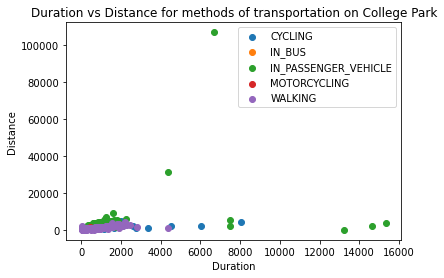

In [96]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for key, grp in finalData.groupby(['activity']):
    plt.scatter(grp['duration'], grp['dist'], label = key)
ax.set_title("Duration vs Distance for methods of transportation on College Park")
ax.set_ylabel("Distance")
ax.set_xlabel("Duration");
plt.legend(loc='best')

Looks like we've discovered a few interesting things here. For one, I only expected to see 3 forms of transportation: cycling, in_passenger_vehicle, and walking. I have taken a bus a couple times and gone on a scooter once or twice as well, so these are showing up in the data. Since there are so few data points for these, I'll remove them and re-try this analysis. There also appears to be a couple outliers that probably represent bad location data from Google, so we should probably remove these points that represent impossibly fast travel. We can find these by sorting our data from fasting travel to slowest and looking at these points on my Google timeline to decide if they are legitimate trips.

In [116]:
# find which points should be removed
for key, grp in finalData.groupby(['activity']):
    print(grp.sort_values(by=['speed'], ascending = False)[['activity','startDateTime','speed','duration','dist']])

     activity       startDateTime      speed  duration    dist
497   CYCLING 2019-10-29 17:51:18  11.890411        73   868.0
381   CYCLING 2019-10-18 13:51:11  11.853659       123  1458.0
411   CYCLING 2019-10-21 19:55:58   8.973333       150  1346.0
5580  CYCLING 2021-09-29 15:45:10   7.380435        92   679.0
373   CYCLING 2019-10-17 14:55:24   6.718121       149  1001.0
...       ...                 ...        ...       ...     ...
6811  CYCLING 2022-01-28 15:48:39   0.518827      8047  4175.0
6839  CYCLING 2022-01-31 16:12:31   0.479249      4530  2171.0
5193  CYCLING 2021-09-04 19:41:17   0.322446      6001  1935.0
6843  CYCLING 2022-01-31 19:31:37   0.300119      3362  1009.0
5829  CYCLING 2021-10-18 18:37:22   0.283448      2773   786.0

[580 rows x 5 columns]
     activity       startDateTime     speed  duration    dist
891    IN_BUS 2019-12-14 04:12:08  3.076923       507  1560.0
747    IN_BUS 2019-11-24 02:11:41  2.905710       753  2188.0
1299   IN_BUS 2020-02-07 01:55:42 

So we have to remove indices 5957 and 6752 since both of these are motorcycling which has too few datapoints for meaningful anaylsis. We also must remove. The two fastest cycling speeds are the only suspect data points with speeds over 11m/s (~20 mph). On further inspection these both represented times when I was going from my dorm (Hagerstown) directly downhill at a time that would be right before class starts. So the more likely explanation is that I was careening down the hill on campus to race to get to my class on time. There are also the 4 data points from times I rode the bus, but I threw away all of these since there's too few of these for meaningful analysis as well. Next, I must consider the times I was driving that seem like outliers. There's only 1 of these where my speed was about 16m/s (over 35 mph) for over 100 km (over 3.5 miles) which at first glance sounds like an impossibility given the traffic situation in College Park. Upon inspection the trip actually represents me getting on the highway, driving to Baltimore, and returning to College Park, which shouldn't be included in analysis. I hadn't considered the possibility of leaving College Park during any trip and returning counting as one trip, but I can actually ensure I don't include any other trips like this by checking that the distance isn't too high like this trip's distance is. Any trip within college park should be less than maybe 10 km. So i'll remove all points that meet this criteria as well. Finally there are the walking activities to consider, and there are a lot of outliers here from trips with durations that are too short. I can fix this by getting rid of all trips under 85 seconds since these are the ones that seem to produce unreasonable speeds. We end up removing about 30 points total by doing this

In [139]:
# Remove all outliers
outliers = (finalData['activity'] == "MOTORCYCLING") | (finalData['activity'] == "IN_BUS")
outliers = outliers | ((finalData['duration'] < 85) & (finalData['activity'] == "WALKING"))
outliers = outliers | (finalData['dist'] > 10000)
finalerData = finalData.drop(finalData[outliers].index)

# Repeat the above analysis to make sure our data looks good now
for key, grp in finalerData.groupby(['activity']):
    print(grp.sort_values(by=['speed'], ascending = False)[['activity','startDateTime','speed','duration','dist']])
print(finalerData['activity'].size)
print(finalData['activity'].size)

     activity       startDateTime      speed  duration    dist
497   CYCLING 2019-10-29 17:51:18  11.890411        73   868.0
381   CYCLING 2019-10-18 13:51:11  11.853659       123  1458.0
411   CYCLING 2019-10-21 19:55:58   8.973333       150  1346.0
5580  CYCLING 2021-09-29 15:45:10   7.380435        92   679.0
373   CYCLING 2019-10-17 14:55:24   6.718121       149  1001.0
...       ...                 ...        ...       ...     ...
6811  CYCLING 2022-01-28 15:48:39   0.518827      8047  4175.0
6839  CYCLING 2022-01-31 16:12:31   0.479249      4530  2171.0
5193  CYCLING 2021-09-04 19:41:17   0.322446      6001  1935.0
6843  CYCLING 2022-01-31 19:31:37   0.300119      3362  1009.0
5829  CYCLING 2021-10-18 18:37:22   0.283448      2773   786.0

[580 rows x 5 columns]
                  activity       startDateTime     speed  duration    dist
7762  IN_PASSENGER_VEHICLE 2022-04-30 04:03:03  8.037901       343  2757.0
4165  IN_PASSENGER_VEHICLE 2021-05-12 21:47:59  7.172222       180  12

Our data is looking really good now so let's repeat this graph now with this new data.

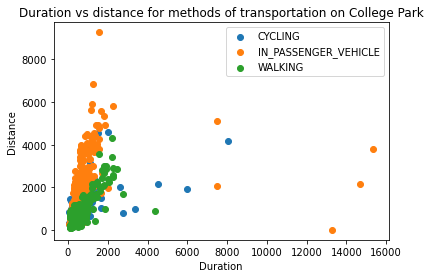

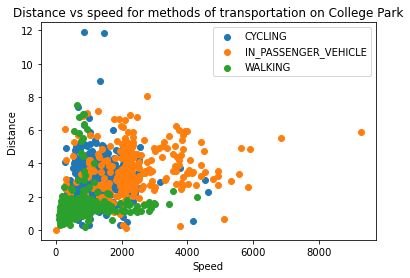

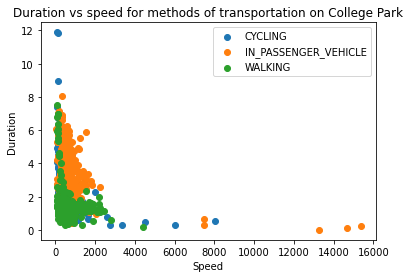

In [142]:
fig, ax = plt.subplots()
for key, grp in finalerData.groupby(['activity']):
    plt.scatter(grp['duration'], grp['dist'], label = key)
ax.set_title("Duration vs distance for methods of transportation on College Park")
ax.set_ylabel("Distance")
ax.set_xlabel("Duration");
plt.legend(loc='best')

fig, ax = plt.subplots()
for key, grp in finalerData.groupby(['activity']):
    plt.scatter(grp['dist'], grp['speed'], label = key)
ax.set_title("Distance vs speed for methods of transportation on College Park")
ax.set_ylabel("Distance")
ax.set_xlabel("Speed");
plt.legend(loc='best')
    
fig, ax = plt.subplots()
for key, grp in finalerData.groupby(['activity']):
    plt.scatter(grp['duration'], grp['speed'], label = key)
ax.set_title("Duration vs speed for methods of transportation on College Park")
ax.set_ylabel("Duration")
ax.set_xlabel("Speed");
plt.legend(loc='best')

In [136]:
cycling = finalData[finalData['activity'] == "CYCLING"]
driving = finalData[finalData['activity'] == "IN_PASSENGER_VEHICLE"]
walking = finalData[finalData['activity'] == "WALKING"]
print(cycling.count())
print(driving.count())
print(walking.count())

startLat         580
startLng         580
endLat           580
endLng           580
startTime        580
endTime          580
dist             580
activity         580
confidence       580
startDateTime    580
endDateTime      580
duration         580
speed            580
dtype: int64
startLat         300
startLng         300
endLat           300
endLng           300
startTime        300
endTime          300
dist             300
activity         300
confidence       300
startDateTime    300
endDateTime      300
duration         300
speed            300
dtype: int64
startLat         301
startLng         301
endLat           301
endLng           301
startTime        301
endTime          301
dist             300
activity         301
confidence       301
startDateTime    301
endDateTime      301
duration         301
speed            300
dtype: int64
